# kepler 시각화 코드

In [ ]:
import json
import pandas as pd

# 11대 위험지표 파일 로드
data = 'TAXI'
data_list = []
file_path = "ps_preprocessing/{}_ovrspd.txt".format(data)

with open("file_path", "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(',')  # 공백을 기준으로 분리
            if len(parts) == 2:
                link_id, count = parts
                data_list.append((int(link_id), int(count)))

#데이터프레임 변환
df = pd.DataFrame(data_list, columns=["vLinkId", "ovrspd"])

# 표준노드링크 파일 로드
with open("link.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# 빠른 조회를 위한 딕셔너리 변환
traffic_dict = df.set_index("vLinkId")["ovrspd"].to_dict()

# GeoJSON 속성값 업데이트 
for feature in geojson_data["features"]:
    properties = feature["properties"]
    link1 = properties.get("up_v_link")
    link2 = properties.get("dw_v_link")

    #위험 지표 데이터의 vLinkId가 up_v_link 또는 dw_v_link에 존재하면 추가
    traffic_count = traffic_dict.get(link1, traffic_dict.get(link2, 0))
    properties["traffic_count"] = traffic_count  # 새로운 속성 추가

# 새로운 GeoJSON 파일 저장
with open("{}_ovrspd.geojson".format(data), "w", encoding="utf-8") as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=4)

print("geojson 변환 완료! 병합 할 것")



In [10]:
import json
from collections import defaultdict

# 병합할 GeoJSON 파일 목록
geojson_files = ["ovrspd_bus.geojson", "ovrspd_taxi.geojson", "ovrspd_truck.geojson"]

# ID 기준으로 Feature들을 병합할 딕셔너리
merged_features = {}

for file in geojson_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        
        for feature in data["features"]:
            feature_id = feature["properties"]["link_id"]
            geometry = feature["geometry"]

            if feature_id not in merged_features:
                # 처음 등장하는 ID일 경우, 새로운 feature 생성
                merged_features[feature_id] = {
                    "type": "Feature",
                    "geometry": geometry,
                    "properties": feature["properties"].copy()
                }
                merged_features[feature_id]["properties"]["traffic_count"] = feature["properties"]["traffic_count"]
            else:
                # 이미 존재하는 ID라면 a 값 누적
                merged_features[feature_id]["properties"]["traffic_count"] += feature["properties"]["traffic_count"]

# 병합된 GeoJSON 생성
merged_geojson = {
    "type": "FeatureCollection",
    "features": list(merged_features.values())
}

# 결과 저장
output_file = "merged.geojson"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(merged_geojson, f, ensure_ascii=False, indent=4)

print(f"병합된 GeoJSON이 {output_file} 파일로 저장되었습니다!")


            vLinkId         ovrspd
count  2.989620e+05  298962.000000
mean   5.729269e+10      37.817686
std    1.169881e+10     192.469894
min    4.123001e+10       1.000000
25%    4.778627e+10       2.000000
50%    5.658132e+10       5.000000
75%    6.472101e+10      18.000000
max    2.023003e+11    7989.000000


In [5]:
import json

# GeoJSON 파일 로드
with open("merged.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# 삭제할 속성 리스트 정의
columns_to_remove = ["up_f_node", "up_t_node", 'dw_f_node', 'dw_t_node', 'road_no', 'link_type', 
                     'pavement', 'road_type', 'up_lanes', 'dw_lanes', 'lanes', 'oneway', 'length', 
                     'up_its_id', 'dw_its_id', 'sido_id', 'sigungu_id', 'emd_id', 'm_date', 'up_v_link', 'dw_v_link',
                      'tg_name', 'rc_id', 'rc_date', 'road_rank', 'rc_name', 'rc_hist', 'rc_length', 'old_link_i', 'source', 'remark', 'max_speed' ]  # 필요 없는 열 추가 가능

# 각 Feature의 properties에서 불필요한 속성 제거
for feature in geojson_data["features"]:
    for col in columns_to_remove:
        feature["properties"].pop(col, None)  # 존재하면 삭제

# 4. 수정된 GeoJSON 저장
with open("ovrspd_merged.geojson", "w", encoding="utf-8") as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=4)

print("필요 없는 속성 삭제 완료! kepler.gl에 업로드하면 끝!")


필요 없는 속성 삭제 완료!


# 기초분석 코드

In [2]:
import json
import pandas as pd

dataframes = {}

for dname in ['BUS', 'TAXI', 'TRUCK']:

    with open(f"{dname}_ovrspd.txt", "r", encoding="utf-8") as f:
        indicator_list = []
        for line in f:
            parts = line.strip().split(',')  
            if len(parts) == 2:
                link_id, count = parts
                indicator_list.append((int(link_id), int(count)))
    dataframes[dname] = pd.DataFrame(indicator_list, columns=["vLinkId", "ovrspd"])
    

dataframes['TAXI'].head()

,vLinkId,ovrspd
0,58214108602,178
1,68120038602,6
2,55121680101,127
3,58124614802,373
4,45741392301,221


In [3]:
taxi_df = dataframes['TAXI']
truck_df = dataframes['TRUCK']
bus_df = dataframes['BUS']

# 기초 분석

print(taxi_df.describe())
print(truck_df.describe())
print(bus_df.describe())

            vLinkId         ovrspd
count  2.159470e+05  215947.000000
mean   5.753428e+10      29.701677
std    1.153379e+10      96.788186
min    4.123001e+10       1.000000
25%    4.777568e+10       2.000000
50%    5.657111e+10       5.000000
75%    6.481004e+10      21.000000
max    2.023003e+11    4046.000000
            vLinkId        ovrspd
count  9.766000e+04  97660.000000
mean   5.679722e+10     22.502591
std    1.158424e+10    201.853377
min    4.123004e+10      1.000000
25%    4.777530e+10      1.000000
50%    5.644290e+10      1.000000
75%    6.423019e+10      4.000000
max    2.023003e+11   6337.000000
            vLinkId         ovrspd
count  1.918150e+05  191815.000000
mean   5.721582e+10      14.047181
std    1.137556e+10      59.950428
min    4.123001e+10       1.000000
25%    4.782419e+10       1.000000
50%    5.666037e+10       3.000000
75%    6.473187e+10       7.000000
max    2.023003e+11    3794.000000


In [4]:
print(bus_df.nlargest(10, 'ovrspd'))  # BUS에서 가장 많이 위반한 링크 10개
print(taxi_df.nlargest(10, 'ovrspd')) # TAXI에서 가장 많이 위반한 링크 10개
print(truck_df.nlargest(10, 'ovrspd')) # TRUCK에서 가장 많이 위반한 링크 10개

             vLinkId  ovrspd
165454   47462412101    3794
138608   47462412801    3412
66680    47462412002    2598
101373   47844790802    2577
34717   202300028002    2563
165450   57115863101    2427
42428    64530942001    2403
22149    47844790801    2340
109102   57115863102    2287
56070    47462400702    2239
            vLinkId  ovrspd
212734  74371255602    4046
24890   74372093201    3977
35668   74270203501    3547
179744  74270203502    3541
50913   58631810202    3416
175468  74270200601    3396
6415    74270203601    3341
89671   74372093202    3324
165787  74270200602    3240
113688  47844790802    3157
           vLinkId  ovrspd
86650  56172875901    6337
26352  56172876301    6332
43399  56172885102    6231
66352  56172883402    6138
40977  56172883401    6082
475    46884712301    6059
94780  46884713602    6058
2      56172883101    6036
17364  56172876302    6034
49334  56172883102    6016


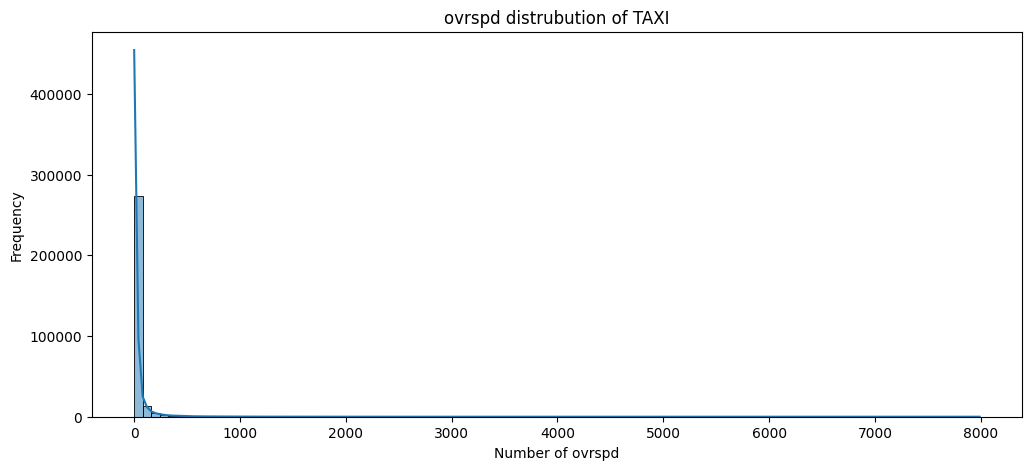

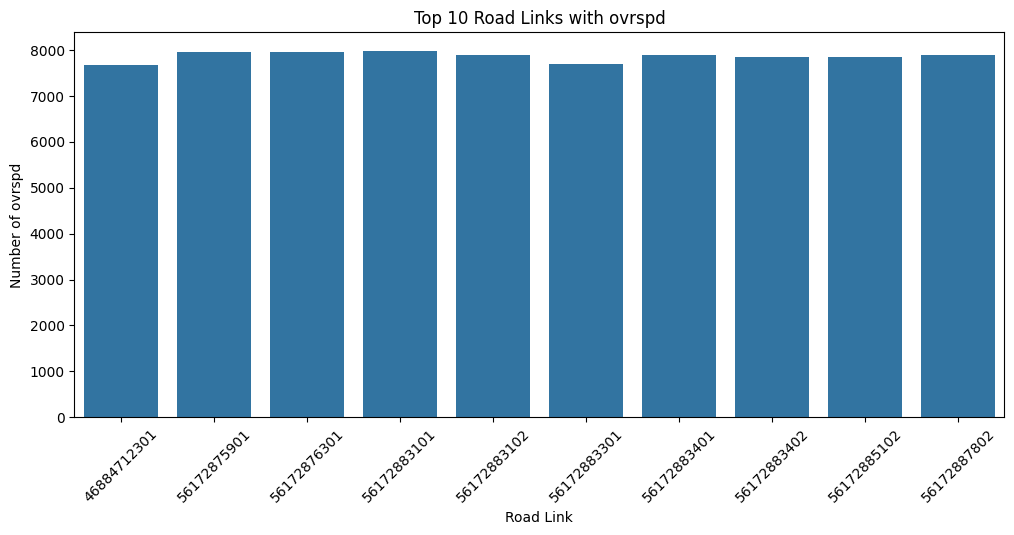

count     298962
unique      1934
top            1
freq       71017
Name: ovrspd, dtype: int64


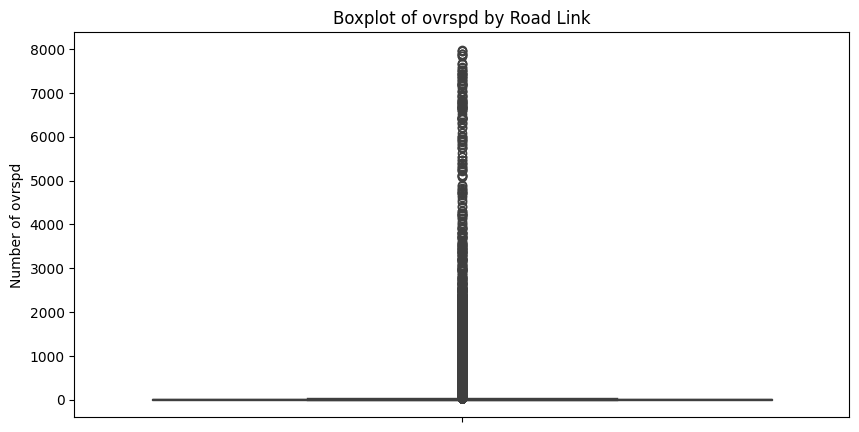

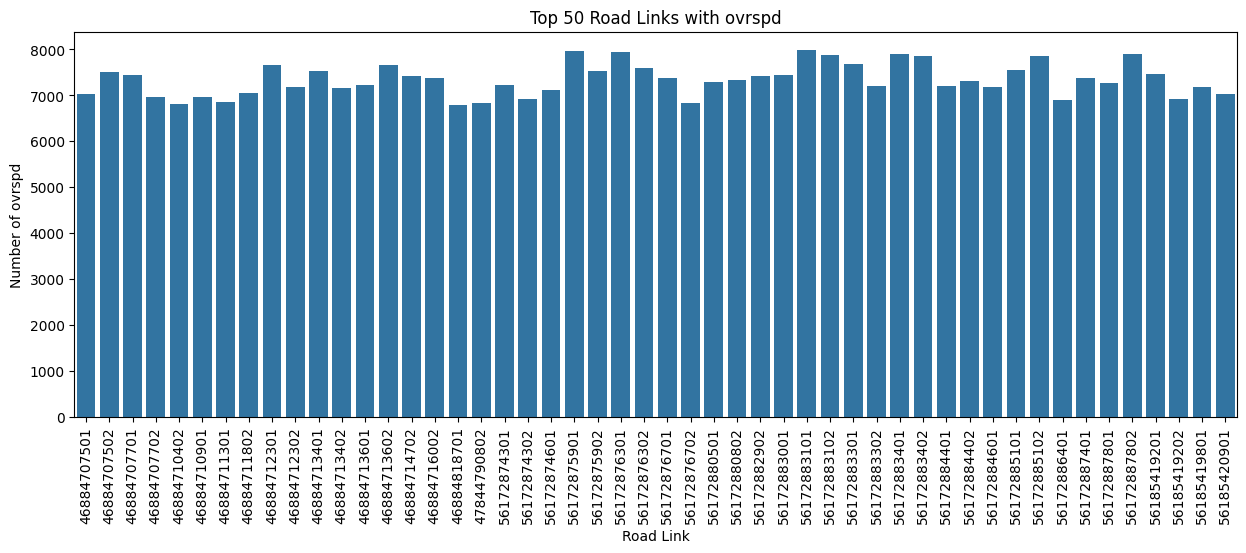

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터 로드
df = result_df

# 1. 도로링크별 속도위반 차량 대수 분포 분석
plt.figure(figsize=(12, 5))
sns.histplot(df["ovrspd"], bins=100, kde=True)
plt.xlabel("Number of ovrspd")
plt.ylabel("Frequency")
plt.title("ovrspd distrubution of TAXI")
plt.show()

# 2. 속도위반이 가장 많은 상위 10개 도로링크
top_links = df.sort_values(by="ovrspd", ascending=False).head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_links["vLinkId"], y=top_links["ovrspd"])
plt.xlabel("Road Link")
plt.ylabel("Number of ovrspd")
plt.title("Top 10 Road Links with ovrspd")
plt.xticks(rotation=45)
plt.show()

# 3. 속도위반 차량 대수의 통계적 분석
summary_stats = df["ovrspd"].describe()
print(summary_stats)

# 4. 도로링크별 속도위반 데이터의 상자그림 (이상치 탐색)
plt.figure(figsize=(10, 5))
sns.boxplot(y=df["ovrspd"])
plt.ylabel("Number of ovrspd")
plt.title("Boxplot of ovrspd by Road Link")
plt.show()

# 5. 도로링크별 속도위반 차량 대수 시각화 (상위 50개)
top_50_links = df.sort_values(by="ovrspd", ascending=False).head(50)
plt.figure(figsize=(15, 5))
sns.barplot(x=top_50_links["vLinkId"], y=top_50_links["ovrspd"])
plt.xlabel("Road Link")
plt.ylabel("Number of ovrspd")
plt.title("Top 50 Road Links with ovrspd")
plt.xticks(rotation=90)
plt.show()


# 지표 검증 (자바 - 파이썬)

## 링크 속도 표준편차

In [6]:
import pandas as pd
import os 

is_first = True
sample_dir = r'C:\Users\QBIC\Desktop\workspace\koti_project\dataset\metric_samples'

for i in range(10, 11):
    input_files = f'link_std_spd_{i}.txt'
    input_dir = os.path.join(sample_dir, input_files)
    input_df = pd.read_csv(input_dir, header = None)
    input_df.columns = ['vLinkId', 'avg_spd', 'timecode', 'weekendcode', 'spd_std', 'total_counts']
    
    if is_first:
        concat_df = input_df
        is_first = False
    else:
        concat_df = pd.concat([concat_df, input_df])

link_std_spd_df = concat_df
link_std_spd_df.head()

,vLinkId,avg_spd,timecode,weekendcode,spd_std,total_counts
0,1000000601,6.305000,10,1,4.857824,2
1,1000016201,13.795000,10,1,7.092281,2
2,1000042300,7.460000,10,1,0.000000,1
3,1010008701,4.820000,10,1,0.000000,1
4,1010010403,3.373333,10,1,0.807486,3


In [2]:
link_std_spd_df.describe()

,vLinkId,avg_spd,timecode,weekendcode,spd_std,total_counts
count,1.293920e+05,129392.000000,129392.000000,129392.0,129392.000000,129392.000000
mean,2.471183e+09,32.523590,9.495193,1.0,6.881249,4.575260
std,8.787137e+08,24.408851,0.499979,0.0,10.986665,7.751594
min,1.000000e+09,0.010000,9.000000,1.0,0.000000,1.000000
25%,1.780078e+09,15.000000,9.000000,1.0,0.000000,1.000000
50%,2.350128e+09,25.700001,9.000000,1.0,3.457486,2.000000
75%,3.100396e+09,43.099999,10.000000,1.0,10.489285,5.000000
max,4.180388e+09,403.169994,10.000000,1.0,420.648318,354.000000


In [3]:
link_std_spd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129392 entries, 0 to 64073
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vLinkId       129392 non-null  float64
 1   avg_spd       129392 non-null  float64
 2   timecode      129392 non-null  int64  
 3   weekendcode   129392 non-null  int64  
 4   spd_std       129392 non-null  float64
 5   total_counts  129392 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 6.9 MB


In [4]:
link_std_spd_df.to_csv('test.csv', index = False)

## 인접링크 속도 편차

In [6]:
import pandas as pd
import os 

is_first = True
sample_dir = r'C:\Users\QBIC\Desktop\workspace\koti_project\dataset\metric_samples'

for i in range(9, 18):
    input_files = f'near_link_spd_{i}.txt'
    input_dir = os.path.join(sample_dir, input_files)
    input_df = pd.read_csv(input_dir, header = None)
    input_df.columns = ['vLinkId', '5km_spd_count', '10km_spd_count', '15km_spd_count', '20km_spd_count', '25km_spd_count', '30km_spd_count', '35km_spd_count', '40km_spd_count', '45km_spd_count', '50km_spd_count', 'ovr50km_spd_count',
                        'timecode', 'weekendcode', 'total_counts']
    
    if is_first:
        concat_df = input_df
        is_first = False
    else:
        concat_df = pd.concat([concat_df, input_df])

near_link_spd_df = concat_df
near_link_spd_df.head()

,vLinkId,5km_spd_count,10km_spd_count,15km_spd_count,20km_spd_count,25km_spd_count,30km_spd_count,35km_spd_count,40km_spd_count,45km_spd_count,50km_spd_count,ovr50km_spd_count,timecode,weekendcode,total_counts
0,1.020040e+09,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,9,1,4
1,1.030007e+09,3.0,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,8
2,1.030023e+09,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1
3,1.030065e+09,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1
4,1.040017e+09,1.0,3.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,1,6


In [7]:
near_link_spd_df.to_csv('near_link_spd.csv', index = False)

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point


# GeoDataFrame - 표준노드링크 네트워크
links_shp = r"D:\MOCT_network\link"  # 링크 파일 경로
moct_gdf = gpd.read_file(links_shp)

In [16]:
moct_gdf['link_id'] = moct_gdf['link_id'].astype(str)
moct_gdf

,link_id,f_node,t_node,lanes,road_rank,road_type,road_no,road_name,road_use,multi_link,connect,max_spd,rest_veh,rest_w,rest_h,length,sido_id,sgg_id,emd_id,geometry
0,2333122000,2330041100,2330043700,1.0,107,000,-,Á¦¾Ï°íÁÖ·Î,0,0,0,40.0,0,0.0,0.0,1183.982106,31000.0,31240.0,31240140.0,"LINESTRING (945747.561 1903150.316, 945741.13 ..."
1,3080340700,3080111800,3080111000,1.0,107,000,-,¿ë¿¬±æ,0,0,0,40.0,0,0.0,0.0,795.566526,35000.0,35030.0,35030430.0,"LINESTRING (952840.299 1778191.839, 952808.268..."
2,3070212800,3070076600,3070077300,1.0,107,000,-,µ¿·É±æ,0,0,0,30.0,0,0.0,0.0,130.307882,35000.0,35020.0,35020530.0,"LINESTRING (929253.782 1777073.903, 929142.543..."
3,4130354400,4130079400,4130086600,1.0,104,000,-,¿Í·æ·Î,0,0,0,60.0,0,0.0,0.0,688.011348,29000.0,29010.0,29010360.0,"LINESTRING (977975.345 1840637.198, 977978.322..."
4,4150113900,4150043000,4150041700,3.0,107,000,-,Ã¢ÀÌ´ë·Î,0,0,0,60.0,0,0.0,0.0,511.532477,38000.0,38112.0,38112540.0,"LINESTRING (1109396.394 1692152.468, 1109293.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548663,2333326002,2330126500,2330293900,1.0,107,000,-,¸ÅÇâ¼®Ãµ·Î,0,0,0,30.0,0,0.0,0.0,682.558842,31000.0,31240.0,31240130.0,"LINESTRING (935125.459 1893746.282, 935157.95 ..."
548664,2030060500,2030027400,2030027600,4.0,107,000,-,±¤±³Áß¾Ó·Î,0,0,0,60.0,0,0.0,0.0,224.403281,31000.0,31014.0,31014620.0,"LINESTRING (960513.611 1920610.864, 960664.725..."
548665,3080338800,3080129900,3080132300,1.0,107,000,-,¿ëµ¿·Î,0,0,0,50.0,0,0.0,0.0,1371.247747,35000.0,35030.0,35030440.0,"LINESTRING (955888.252 1789179.984, 955887.987..."
548666,3620319600,3620113600,3620113800,1.0,107,000,-,°í¿î»ç±æ,0,0,0,50.0,0,0.0,0.0,1403.269761,37000.0,37520.0,37520310.0,"LINESTRING (1109451.739 1829739.451, 1109482.4..."


In [13]:
link_std_spd_df['vLinkId'].unique().shape

(33271,)

In [14]:
moct_gdf[moct_gdf['link_id'].isin(link_std_spd_df['vLinkId'].values)]

,link_id,f_node,t_node,lanes,road_rank,road_type,road_no,road_name,road_use,multi_link,connect,max_spd,rest_veh,rest_w,rest_h,length,sido_id,sgg_id,emd_id,geometry
6,1790129203,1790044201,1790045700,3.0,104,000,-,Àå½Å·Î,0,0,0,50.0,0,0.0,0.0,297.848300,24000.0,24050.0,24050521.0,"LINESTRING (940203.517 1688716.291, 940210.597..."
22,1760149301,1760002300,1760002302,2.0,104,000,-,³»¹æ·Î,0,0,0,50.0,0,0.0,0.0,307.196812,24000.0,24020.0,24020600.0,"LINESTRING (943802.543 1684829.204, 943890.186..."
23,1760163300,1760052900,1760002500,8.0,104,000,-,¹«Áø´ë·Î,0,0,0,60.0,0,0.0,0.0,578.558422,24000.0,24020.0,24020560.0,"LINESTRING (943270.754 1685304.341, 943791.783..."
31,1930045900,1930020900,1930016700,2.0,104,000,-,³²ºÎ¼øÈ¯µµ·Î,0,0,0,80.0,0,0.0,0.0,2224.376252,26000.0,26020.0,26020600.0,"LINESTRING (1160312.253 1727567.428, 1160315.6..."
38,1130040800,1130018400,1180065000,4.0,103,003,6,¼±À¯·Î,0,0,0,60.0,0,0.0,0.0,574.569589,11000.0,11140.0,11140680.0,"LINESTRING (947701.299 1949860.687, 947467.928..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548608,1060065500,1060009400,1060009100,3.0,104,000,-,»ç°¡Á¤·Î,0,0,0,50.0,0,0.0,0.0,67.677045,11000.0,11070.0,11070550.0,"LINESTRING (962888.976 1953647.817, 962869.284..."
548609,1070012402,1070041200,1070022000,3.0,104,000,-,Á¤¸ª·Î,0,0,0,50.0,0,0.0,0.0,521.741460,11000.0,11080.0,11080620.0,"LINESTRING (957662.649 1955971.649, 957516.391..."
548648,2090023600,2090008800,2090008900,1.0,107,000,-,½Å±â´ë·Î,0,0,0,50.0,0,0.0,0.0,71.688576,31000.0,31042.0,31042660.0,"LINESTRING (951968.446 1931266.145, 951938.487..."
548656,1060066800,1060029800,1060030000,1.0,104,000,-,½Å³»·Î25±æ,0,0,0,30.0,0,0.0,0.0,155.103671,11000.0,11070.0,11070640.0,"LINESTRING (963339.886 1957844.423, 963340.567..."
